In [1]:
from ase.io import read
from pathlib import Path
from dscribe.descriptors import SOAP, ACSF
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [79]:
global_path = Path('/home/ebychkov/Teach/HPPL_project/')

structure_file = global_path / 'data' / 'HfB2_5gr_p1.dat'
structure = read(structure_file, format='lammps-data')
unique_symbols = set(structure.symbols)
print(unique_symbols)
len(structure)

{'Hf', 'B'}


9135

In [80]:
species_str = np.array(list(unique_symbols))
R_cut = 8
n_max = 8
l_max = 4

In [81]:
species_str

array(['Hf', 'B'], dtype='<U2')

In [16]:
acsf = ACSF(
    species=species_str,        # Список всех возможных элементов в твоем датасете
    r_cut=R_cut,                  # Радиус сферы окружения (в Ангстремах)
    g2_params=[[1, 2], [1, 4]], # Параметры радиальных функций [[eta, Rs], ...]
    g4_params=[[1, 2, 1]],      # Параметры угловых функций [[eta, zeta, lambda], ...]
    periodic=True,             # Важно: False для молекул, True для кристаллов
    sparse=False                # Возвращать обычный numpy массив (быстрее для GPU/Torch)
)

In [82]:
soap = SOAP(
    species=species_str,
    periodic=True,
    r_cut=R_cut,
    n_max=n_max,
    l_max=l_max,
    compression = {'mode':'mu2'})

In [18]:
# %%timeit
# local_environments = acsf.create(structure, n_jobs=1)

In [83]:
local_enviroments = soap.create(structure, n_jobs = 1)

In [84]:
local_enviroments.shape

(9135, 180)

In [21]:
# %timeit local_enviroments = soap.create(structure, n_jobs = 2)

# local_enviroments.shape
a =

SyntaxError: invalid syntax (1792270520.py, line 4)

In [23]:
n_tests = 1
time_arr = []
for n_jobs in range(1, 6):
    total_time = timeit.timeit(lambda: soap.create(structure, n_jobs=n_jobs), number=n_tests)
    time_arr.append(total_time/ n_tests)

In [24]:
time_arr =np.array( time_arr)

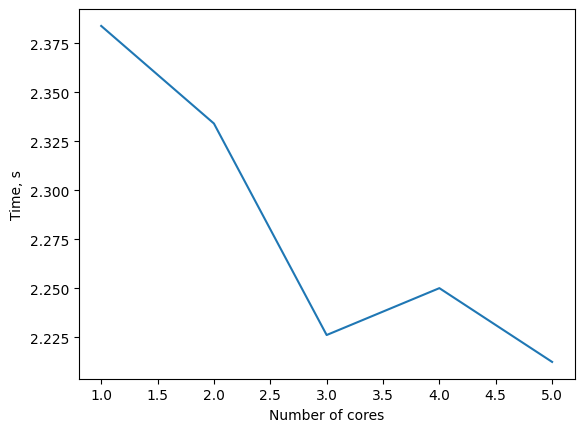

In [25]:
plt.plot(np.arange(1, 6), time_arr)
plt.xlabel("Number of cores")
plt.ylabel("Time, s")
plt.savefig(global_path/ 'tests' / 'check_time_small_str.png')
plt.show()

In [ ]:
total_time = timeit.timeit(lambda: soap.create(structure, n_jobs=4), number=2)
total_time

2.8520547673106194

In [32]:
%%writefile  /home/ebychkov/Teach/HPPL_project/testin_speed.py
from ase.io import read
from pathlib import Path
from dscribe.descriptors import SOAP, ACSF
import timeit
import logging
import matplotlib.pyplot as plt
import numpy as np
global_path = Path('/home/ebychkov/Teach/HPPL_project/')
logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(global_path/ 'tests'/ 'app.log'),
        logging.StreamHandler()  # также выводит в консоль
    ]
)
logger = logging.getLogger(__name__)
logger.info('Отладка началась')

structure_file = global_path / 'data' / 'HfB2_5gr_p1.dat'
structure = read(structure_file, format='lammps-data')
logger.info("Структура считана успешно")
species_str = ["Ti", "Zr", "Ta", "Hf", "Nb", "B"]
R_cut = 8
n_max = 6
l_max = 3
soap = SOAP(
    species=species_str,
    periodic=False,
    r_cut=R_cut,
    n_max=n_max,
    l_max=l_max,
    compression = {'mode':'mu2'})
acsf = ACSF(
    species=species_str,        # Список всех возможных элементов в твоем датасете
    r_cut=R_cut,                  # Радиус сферы окружения (в Ангстремах)
    g2_params=[[1, 2], [1, 4]], # Параметры радиальных функций [[eta, Rs], ...]
    g4_params=[[1, 2, 1]],      # Параметры угловых функций [[eta, zeta, lambda], ...]
    periodic=True,             # Важно: False для молекул, True для кристаллов
    sparse=False                # Возвращать обычный numpy массив (быстрее для GPU/Torch)
)

logger.info('Запускаем расчет для маленькой структуры')
n_tests = 10
time_arr = []
for n_jobs in range(1, 24):
    logger.debug(f'Small {n_jobs}')
    total_time = timeit.timeit(lambda: soap.create(structure, n_jobs=n_jobs), number=n_tests)
    time_arr.append(total_time/ n_tests)
logger.info('Закончили расчет для маленькой структуры')
plt.plot(np.arange(1, 6), time_arr)
plt.xlabel("Number of cores")
plt.ylabel("Time, s")
plt.savefig(global_path/ 'tests' / 'check_time_small_str.png')
plt.show()
logger.info('Сохранили файл расчет для маленькой структуры')
supercell = structure * (5, 5, 4)
n_tests = 3
time_arr_big = []
n_cores_big = [1, 2, 4, 8, 12, 24]
logger.info('Запускаем расчет для большой структуры')
for n_jobs in n_cores_big:
    logger.debug(f'Big {n_jobs}')
    total_time = timeit.timeit(lambda: soap.create(supercell, n_jobs=n_jobs), number=n_tests)
    time_arr_big.append(total_time/ n_tests)
logger.info('Закончили расчет для большой структуры')
plt.plot(n_cores_big, time_arr_big)
plt.xlabel("Number of cores")
plt.ylabel("Time, s")
plt.savefig(global_path/ 'tests' / 'check_time_big_str.png')
plt.show()

Overwriting /home/ebychkov/Teach/HPPL_project/testin_speed.py


In [22]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(local_enviroments)
pca = PCA(n_components=3)
df_after_PCA = pca.fit_transform(X=df_scaled)
df_after_PCA.shape

(28938, 3)

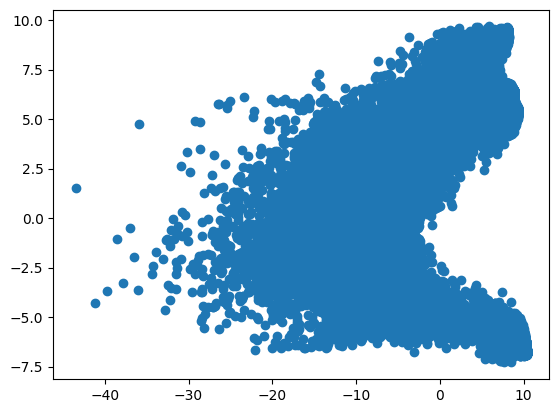

In [62]:
plt.scatter(df_after_PCA[:,0], df_after_PCA[:, 1])

In [61]:
# import plotly.graph_objects as go
# import numpy as np

# # Тестовый график
# fig = go.Figure(data=[go.Scatter3d(
#     x=df_after_PCA[:, 0],
#     y=df_after_PCA[:, 1],
#     z=df_after_PCA[:, 2],
#     mode='markers',
#     marker=dict(size=3)
# )])
# fig.show()

In [85]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(local_enviroments)
pca = PCA(n_components=0.93)
df_after_PCA = pca.fit_transform(X=df_scaled)
df_after_PCA.shape

(9135, 33)

In [86]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

def check_optimal_epsilon(k, df_after_PCA):
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(df_after_PCA)
    distances, indices = neighbors_fit.kneighbors(df_after_PCA)
    distances = np.sort(distances[:, k-1], axis=0)

    # Рисуем график
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.title(f"График k-расстояний (k={k})")
    plt.xlabel("Точки, отсортированные по расстоянию")
    plt.ylabel(f"Расстояние до {k}-го соседа (Eps candidate)")
    plt.grid(True)
    plt.show()

In [87]:
import plotly.express as px
def visualise_str_labels(structure, labels):
    positions = structure.get_positions()
    df = pd.DataFrame({
    'x': positions[:, 0],
    'y': positions[:, 1],
    'z': positions[:, 2],
    'category': labels,
    })

    # Способ 1: Plotly Express (проще)
    fig = px.scatter_3d(df, 
                        x='x', y='y', z='z',
                        color='category',  # цвет по категории
                        symbol='category',  # разные маркеры для категорий     # размер по числовой переменной
                        opacity=0.8,
                        title='3D точки с категориальными признаками',
                        color_discrete_sequence=px.colors.qualitative.Set1)
    fig.update_layout(coloraxis_showscale=False)
    fig.show()

In [74]:
def clusterisation(k, eps, df_after_PCA):
    CHOSEN_EPS = eps
    CHOSEN_MIN_SAMPLES = k # То же k, что использовали выше

    print(f"Запуск DBSCAN с eps={CHOSEN_EPS}...")
    db = DBSCAN(eps=CHOSEN_EPS, min_samples=CHOSEN_MIN_SAMPLES, n_jobs=-1)
    labels = db.fit_predict(df_after_PCA)
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print(f"Найдено кластеров: {n_clusters_}")
    print(f"Точек шума (выбросов): {n_noise_}")
    return(labels)
    

In [66]:
import umap

In [88]:
reducer = umap.UMAP(
    n_neighbors=30,
    n_components=10,  # Сжимаем до 10 измерений для кластеризации
    min_dist=0.0,
    metric='cosine',
    n_jobs = 4# Для высокой размерности cosine часто лучше euclidean
)
embedding = reducer.fit_transform(df_scaled)

/home/ebychkov/miniforge3/envs/HPPL_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



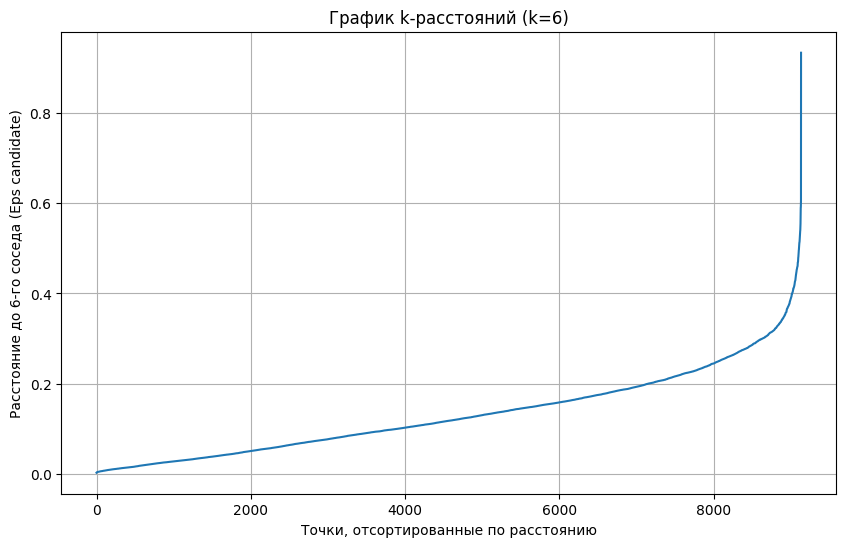

In [89]:
check_optimal_epsilon(6, embedding)

In [92]:
visualise_str_labels(structure, clusterisation(6,0.5, embedding))

Запуск DBSCAN с eps=0.5...
Найдено кластеров: 8
Точек шума (выбросов): 3
